In [469]:
from IPython.display import HTML

HTML('''
<style>
    .cell.code_cell .input {display: none;}
</style>
''')

# ADDAM clustering 

We conducted clustering analysis on the 129 samples based on their clinical, genotype and antibody data.

Conclusion:

* We first tried simple K-means clustering, and find the clustering was most driven by the genotype profiles, specifically the insulin gene (INS) and the MHC region. 

* We then tried the hierarchical clustering. The clustering results was driven by the genotype profiles from the MHC region. The ZnT8 antobidy level are also associated with the HC clustering results, but not statically significant after multiple testing correction.

* Finally we tried the Fuzzy C-means clustering, and the clustering was driven by the MHC region SNPs and the INS genotypes.  The ZnT8 antobidy level are also associated with the HC clustering results, but not statically significant after multiple testing correction.

* Note that all the three clustering methods have identified optimal number of clusters = 2, and the clustering results are consistently align with the top 2 principle components of the PCA analysis.

* All clinical profiles are not statistically significant in all three clustering results.

* The UMAP analysis did not show anything interesting.

## Genotype Data Processing 

We first collected the genotype data of the first batch of 129 samples. The summary statistics are shown as below.



In [ ]:
import pandas as pd
import pandas_plink

file_path = 'dat/AM.JDRF.SHARP.fam'


(bim, fam, bed) = pandas_plink.read_plink("dat/AM.JDRF.SHARP")


print("BIM (SNP Information):")
print(bim.head())

print("\nUnique Chromosome Values:")
print(bim['chrom'].unique())

print("\nFAM (Family and Individual Information):")
print(fam.head())

print("\nGender Distribution (from FAM file):")
print(fam['gender'].value_counts())

print("\nBED (Genotype Data Matrix Shape):")
print(bed.shape)

genotype_data_slice = bed[:, :5].compute()  # Compute the first 5 columns for all individuals



Mapping files: 100%|██████████| 3/3 [00:00<00:00, 19.63it/s]


BIM (SNP Information):
  chrom                 snp   cm        pos a0 a1  i
0     1  chr1:113761186:C:A  0.0  113761186  A  C  0
1     1  chr1:206766559:G:A  0.0  206766559  A  G  1
2     2  chr2:162254026:A:G  0.0  162254026  A  G  2
3     2  chr2:203874196:G:A  0.0  203874196  A  G  3
4     4  chr4:122408207:G:A  0.0  122408207  A  G  4

FAM (Family and Individual Information):
           fid          iid father mother gender trait  i
0  -_01-003-01  -_01-003-01      0      0      0    -9  0
1  -_01-004-01  -_01-004-01      0      0      0    -9  1
2  -_01-007-01  -_01-007-01      0      0      0    -9  2
3  -_01-010-01  -_01-010-01      0      0      0    -9  3
4  -_01-013-01  -_01-013-01      0      0      0    -9  4

Gender Distribution (from FAM file):
gender
0    129
Name: count, dtype: Int64

BED (Genotype Data Matrix Shape):
(72, 129)


## Clinical data Processing


We then collect the clinical information of the all 448 samples. 

There are 27 clinical features on record. We manually curated the following features for clustering:

* patients age (birthdate to date 1 Oct, 2024)
* patients sex (at birth)
* diabete histories (date of dianosis to date 1 Oct, 2024)
* diabetes in siblings (yes or no, 0 or 1) N = 47
* diabetes in father (0 or 1)   N = 38
* diabetes in mother (0 or 1)   N = 30
* patients father or mother have diabetes (yes or no, 0 or 1)  N = 62
* patients first degree relatives have diabetes AND diabetes in other family members. N = 34 
* height
* weight
* insulin dosages
* A1c results in average


(448, 27)
Index(['Record ID (XX-XXX-XX)', 'Visit Date ', 'Subject's Date of Birth',
       'Subject's Sex at Birth', 'Date of diabetes diagnosis',
       'Are any of the subject's siblings diagnosed with diabetes (any type)?',
       'Is the subject's mother diagnosed with diabetes (any type)?',
       'Is the subject's father diagnosed with diabetes (any type)?',
       'If a first degree relative of the subject has diabetes (mother, father or sibling), is there diabetes in any of the following family members? (check all that apply) (choice=Paternal grandfather)',
       'If a first degree relative of the subject has diabetes (mother, father or sibling), is there diabetes in any of the following family members? (check all that apply) (choice=Paternal grandmother)',
       'If a first degree relative of the subject has diabetes (mother, father or sibling), is there diabetes in any of the following family members? (check all that apply) (choice=Paternal uncle (s))',
       'If a first d

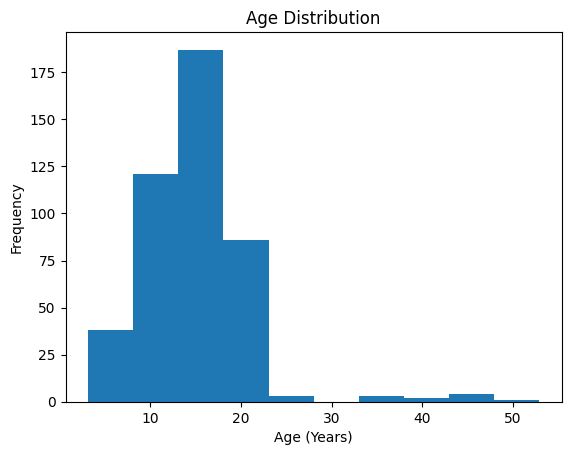

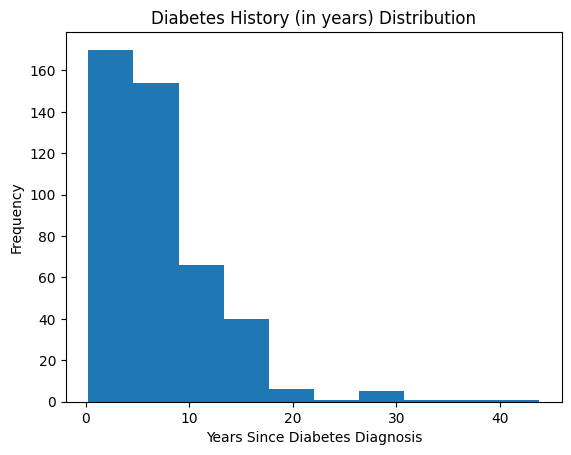

Subject's Sex at Birth
Male      116
Female     94
Name: count, dtype: int64
Cluster_sex
-1    238
 1    116
 0     94
Name: count, dtype: int64
Cluster_diabetes_siblings
0    401
1     47
Name: count, dtype: int64
Cluster_diabetes_father
0    410
1     38
Name: count, dtype: int64
Cluster_diabetes_mother
0    418
1     30
Name: count, dtype: int64
Cluster_diabetes_parents
0    386
1     62
Name: count, dtype: int64
Cluster_family_diabetes
0    414
1     34
Name: count, dtype: int64


In [ ]:
from matplotlib import pyplot as plt
import pandas as pd

data = pd.read_csv('dat/participants.csv')

print(data.shape)

print(data.columns)

# "Cluster_age", the value is the difference between 'Subject's Date of Birth' to Oct 1, 2024 and divide by 365
data['Cluster_age'] = (pd.to_datetime('2024-10-01') - pd.to_datetime(data['Subject\'s Date of Birth']))/pd.Timedelta(days=365)

plt.figure()  
data['Cluster_age'].plot.hist(title='Age Distribution')
plt.xlabel('Age (Years)')
plt.show()



# "Cluster_diabete_history", the value is the difference between Date of diabetes diagnosis' to Oct 1, 2024 and divide by 365
data['Cluster_diabete_history'] = (pd.to_datetime('2024-10-01') - pd.to_datetime(data['Date of diabetes diagnosis']))/pd.Timedelta(days=365)


plt.figure()  
data['Cluster_diabete_history'].plot.hist(title='Diabetes History (in years) Distribution')
plt.xlabel('Years Since Diabetes Diagnosis')
plt.show()

#print the table counts of  'Subject's Sex at Birth'
print(data["Subject's Sex at Birth"].value_counts())

data['Cluster_sex'] = data["Subject's Sex at Birth"].apply(lambda x: 1 if x == "Male" else 0 if x == "Female" else -1)    
print(data["Cluster_sex"].value_counts())


#* diabetes in siblings (yes or no, 0 or 1)
data['Cluster_diabetes_siblings'] = data["Are any of the subject's siblings diagnosed with diabetes (any type)?"].apply(lambda x: 1 if x == "Yes" else 0 if x == "No" else 0)
print(data["Cluster_diabetes_siblings"].value_counts())

# patients father  have diabetes (yes or no, 0 or 1)
data['Cluster_diabetes_father'] = data["Is the subject's father diagnosed with diabetes (any type)?"].apply(lambda x: 1 if x == "Yes" else 0 if x == "No" else 0)
print(data["Cluster_diabetes_father"].value_counts())

# patients mother  have diabetes (yes or no, 0 or 1)
data['Cluster_diabetes_mother'] = data["Is the subject's mother diagnosed with diabetes (any type)?"].apply(lambda x: 1 if x == "Yes" else 0 if x == "No" else 0)
print(data["Cluster_diabetes_mother"].value_counts())

#patients mother or father have diabetes = Cluster_diabetes_mother + Cluster_diabetes_father
data['Cluster_diabetes_parents'] = data['Cluster_diabetes_mother'] + data['Cluster_diabetes_father']
#then binarize the value
data['Cluster_diabetes_parents'] = data['Cluster_diabetes_parents'].apply(lambda x: 1 if x > 0 else 0)
print(data["Cluster_diabetes_parents"].value_counts())

#curate the Cluster_family_diabetes
columns_to_check = [
    'If a first degree relative of the subject has diabetes (mother, father or sibling), is there diabetes in any of the following family members? (check all that apply) (choice=Paternal grandfather)',
    'If a first degree relative of the subject has diabetes (mother, father or sibling), is there diabetes in any of the following family members? (check all that apply) (choice=Paternal grandmother)',
    'If a first degree relative of the subject has diabetes (mother, father or sibling), is there diabetes in any of the following family members? (check all that apply) (choice=Paternal uncle (s))',
    'If a first degree relative of the subject has diabetes (mother, father or sibling), is there diabetes in any of the following family members? (check all that apply) (choice=Paternal aunt (s))',
    'If a first degree relative of the subject has diabetes (mother, father or sibling), is there diabetes in any of the following family members? (check all that apply) (choice=Maternal grandfather)',
    'If a first degree relative of the subject has diabetes (mother, father or sibling), is there diabetes in any of the following family members? (check all that apply) (choice=Maternal grandmother)',
    'If a first degree relative of the subject has diabetes (mother, father or sibling), is there diabetes in any of the following family members? (check all that apply) (choice=Maternal uncle (s))',
    'If a first degree relative of the subject has diabetes (mother, father or sibling), is there diabetes in any of the following family members? (check all that apply) (choice=Maternal aunt (s))'
]

data['Cluster_family_diabetes'] = data[columns_to_check].apply(lambda row: 1 if 'Checked' in row.values else 0, axis=1)
#multiple the value by Cluster_diabetes_parents
data['Cluster_family_diabetes'] = data['Cluster_family_diabetes']*data['Cluster_diabetes_parents']
print(data["Cluster_family_diabetes"].value_counts())

data['Cluster_subjectID'] = data['Record ID (XX-XXX-XX)']
data['Cluster_height'] = data["Subject's height (cm)"]
data['Cluster_weight'] = data["Subject's weight (kg)"]
data['Cluster_insulin'] = data['Current insulin total daily dose (number of units)']
data['Cluster_A1c'] = data['Average of A1c results']

       
       
cluster_data = data.filter(regex='Cluster*')

cluster_data.to_csv('dat/cluster_clinical.csv', index=False)


We then collect the antibody data of the total 1377 samples for the three types of antibodies: 96GAD, IA2, and ZnT8.
We then match the 129 samples with the 1377 samples and get the antibody data for the 129 samples.

In [ ]:
import pandas as pd

all_sheets = pd.read_excel('dat/antibody.xlsx', sheet_name=None)

# Columns to keep
columns_to_keep = ['Subject', '96GAD Qual', '96GAD Index', "Draw Date", 'IA2 Qual', 'IA2 Index', 'ZnT8 Qual', 'ZnT8 Index']

# List to store filtered DataFrames
filtered_dataframes = []

for sheet_name, df in all_sheets.items():
    filtered_df = df.loc[:, df.columns.intersection(columns_to_keep)]
    
    filtered_dataframes.append(filtered_df)
    


# Concatenate all the filtered DataFrames by rows
combined_data = pd.concat(filtered_dataframes, ignore_index=True)

print("\nCombined antibody Data:")
print(combined_data.head())
print(combined_data.shape)
print(combined_data['Subject'].nunique())

combined_data.to_csv('dat/antibody_filtered.csv', index=False)



Combined antibody Data:
      Subject            Draw Date 96GAD Qual  96GAD Index IA2 Qual  \
0  01-209-01   2022-12-13 00:00:00        POS     1.213200      NaN   
1   09-005-01  2022-10-11 00:00:00        POS     1.148355      NaN   
2   01-205-01  2022-12-06 00:00:00        POS     0.995129      NaN   
3   01-225-01  2023-01-31 00:00:00        POS     0.976766      NaN   
4   05-031-01  2023-01-10 00:00:00        POS     0.896709      NaN   

   IA2 Index ZnT8 Qual  ZnT8 Index  
0        NaN       NaN         NaN  
1        NaN       NaN         NaN  
2        NaN       NaN         NaN  
3        NaN       NaN         NaN  
4        NaN       NaN         NaN  
(2599, 8)
1377


In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
# Assuming 'fam' and 'combined_data' are already loaded

cluster_subject_id = fam['iid']

cluster_subject_id = cluster_subject_id.apply(lambda x: x[2:])

cluster_antibody_data = combined_data[combined_data['Subject'].isin(cluster_subject_id)]


# Antibody list of columns to work with
columns_antibody_list = ['96GAD Qual', '96GAD Index', 'Draw Date', 'IA2 Qual', 'IA2 Index', 'ZnT8 Qual', 'ZnT8 Index']

cluster_antibody_data['Draw Date'] = pd.to_datetime(cluster_antibody_data['Draw Date'])

cluster_antibody_data = cluster_antibody_data.sort_values(by=['Subject', 'Draw Date'], ascending=[True, False])

def get_most_recent_non_missing(group):
    result = {'Subject': group['Subject'].iloc[0], 'Draw Date': group['Draw Date'].iloc[0]}
    
    valid_qual_values = ['POS', 'neg']
    
    for col in columns_antibody_list:
        if col in ['96GAD Qual', 'IA2 Qual', 'ZnT8 Qual']:
            result[col] = next((val for val in group[col] if val in valid_qual_values), None)
        else:
            # For other columns, get the first non-missing value
            result[col] = group[col].dropna().iloc[0] if not group[col].dropna().empty else None
    return pd.Series(result)

most_recent_antibodies = cluster_antibody_data.groupby('Subject').apply(get_most_recent_non_missing)

print("110 matched subject (genotype, clinical and antibody) antibody data dimension:", most_recent_antibodies.shape)

most_recent_antibodies.to_csv('results/cluster_Oct_antibody_final.csv', index=False)


missing_subjects = cluster_subject_id[~cluster_subject_id.isin(most_recent_antibodies['Subject'])]


110 matched subject (genotype, clinical and antibody) antibody data dimension: (110, 8)


For genotype data, we create a matrix of 129X 216, where 129 is the number of samples and 72 is the number of SNPs. Each SNP have 3 genotype status: 0, 1, 2, corresponding to homozygous, heterozygous, and homozygous respectively.


In [ ]:
import pandas as pd

snp_names = bim['snp'].tolist() 
genotype_data = bed.compute()  # Load the genotype data

print(f"Shape of genotype_data: {genotype_data.shape}")

# Assign SNP names to the rows (index) of the DataFrame, and keep columns as default for now
genotype_df = pd.DataFrame(genotype_data, index=snp_names)


genotype_df.columns = cluster_subject_id

import pandas as pd

num_rows, num_cols = genotype_df.shape

# Initialize a new DataFrame with 3 times the number of rows in genotype_df
new_df = pd.DataFrame(index=range(num_rows * 3), columns=range(num_cols))

for i in range(num_rows):
    # Get the current row of genotype_df
    current_row = genotype_df.iloc[i]
    
    # First new row: elements equal to 1
    new_df.iloc[i * 3] = (current_row == 1).astype(int)
    
    # Second new row: elements equal to 2
    new_df.iloc[i * 3 + 1] = (current_row == 2).astype(int)
    
    # Third new row: elements equal to 3
    new_df.iloc[i * 3 + 2] = (current_row == 3).astype(int)

transposed_df = new_df.T

transposed_df['Subject'] = cluster_subject_id

transposed_df.to_csv('results/cluster_Oct_genotype.csv', index=False)


Shape of genotype_data: (72, 129)


We finally combine the genotype data, clinical data and antibody data for the overlapping samples N = 110.

After combing three datasets, in addition to the column of subject ID, we have a numeric feature matrix of 110 X 234, where 110 is the number of samples and 234 is the number of features:

* 216 genotype features
* 12 clinical features
* 6 antibody features

Note: among all 110 subjects with all three data for clustering analysis, only 1 subject is recorded as male in the raw clinical data. 

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Load the genotype data
genotype_data = pd.read_csv('results/cluster_Oct_genotype.csv')

#load clinical data
clinical_data = pd.read_csv('dat/cluster_clinical.csv')
#rename Cluster_subjectID to Subject
clinical_data = clinical_data.rename(columns={'Cluster_subjectID': 'Subject'})

#load antibody data
antibody_data = pd.read_csv('results/cluster_Oct_antibody_final.csv')


# Step 1: Find the overlapping Subject IDs
overlapping_subjects = set(genotype_data['Subject']).intersection(
    set(clinical_data['Subject'])).intersection(set(antibody_data['Subject']))

# Convert the overlapping Subject IDs back to a list
overlapping_subjects = list(overlapping_subjects)

# Step 2: Subset the datasets to include only the overlapping Subject IDs
genotype_subset = genotype_data[genotype_data['Subject'].isin(overlapping_subjects)]
clinical_subset = clinical_data[clinical_data['Subject'].isin(overlapping_subjects)]
antibody_subset = antibody_data[antibody_data['Subject'].isin(overlapping_subjects)]


# Print table counts of cluster_sex in clinical_data
cluster_sex_counts = clinical_subset['Cluster_sex'].value_counts()
print("The table counts of the sex at birth record of the 110 subjects for clustering analysis:")
print(cluster_sex_counts)

      
# Step 3: Merge the datasets on the 'Subject' column
merged_data = genotype_subset.merge(clinical_subset, on='Subject').merge(antibody_subset, on='Subject')



#remove the Draw Date column
merged_data = merged_data.drop('Draw Date', axis=1)

#replace the POS and neg with 1 and 0 numerics
merged_data['96GAD Qual'] = merged_data['96GAD Qual'].replace({'POS': 1, 'neg': 0})
merged_data['IA2 Qual'] = merged_data['IA2 Qual'].replace({'POS': 1, 'neg': 0})
merged_data['ZnT8 Qual'] = merged_data['ZnT8 Qual'].replace({'POS': 1, 'neg': 0})

# Step 4: Print the shape and first few rows of the merged dataset to verify
print(f"Shape of the merged dataset: {merged_data.shape}")



merged_data.to_csv('results/cluster_Oct_merged.csv', index=False)


The table counts of the sex at birth record of the 110 subjects for clustering analysis:
Cluster_sex
-1    109
 1      1
Name: count, dtype: int64
Shape of the merged dataset: (110, 235)


## Clustering analysis

We conducted clustering analysis on the 110 samples based on their clinical and genotype data. We followed the following steps:

* Preprocess: Standardization of the feature matrix.
* Dimensionality Reduction: Explore PCA and UMAP for dimension reduction and preliminary data cluster patterns.
* Cluster: Apply clustering algorithms (e.g., K-Means and Hierarchical).
* Visualize: Use PCA to visualize the clusters.
* Interpret: Analyze how the clusters relate to clinical and antibody data for insights.

Note that we first process the data with standardization to ensure that each feature contributes equally to the clustering process. 

### PCA Analysis (principal component analysis)

We then conduct PCA to see if we can reduce the dimensionality of the data. The result below shows the top 2 principle components can only explain 10% of the variance. The top 20 principle components can explain 60% of the variance.


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Separate clinical and genotype features
features = merged_data.drop(columns=['Subject'])  

imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

pd.DataFrame(features_scaled).to_csv('results/scaled_features.csv', index=False)


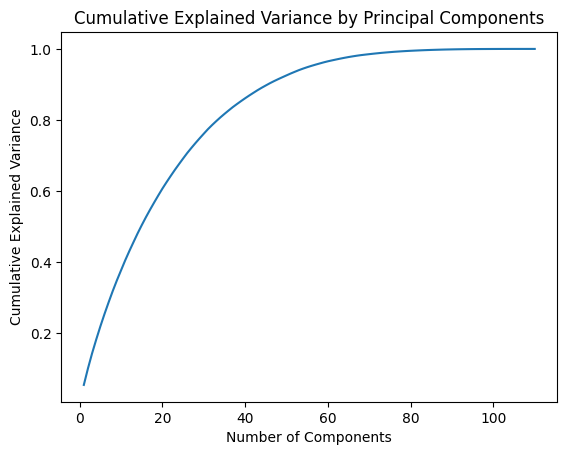

Cumulative explained variance by top 20 components:
[0.055, 0.101, 0.143, 0.182, 0.219, 0.254, 0.287, 0.319, 0.349, 0.377, 0.405, 0.431, 0.456, 0.481, 0.504, 0.526, 0.547, 0.568, 0.588, 0.607]
Number of components required to explain 80% of the variance: 34
Number of components required to explain 90% of the variance: 46


In [ ]:


from sklearn.decomposition import PCA
import seaborn as sns



# calculate the PCA and contribution to variance of each components

# Apply PCA to the scaled features
pca = PCA()
pca.fit(features_scaled)  
explained_variance_ratio = pca.explained_variance_ratio_

cumulative_variance_ratio = explained_variance_ratio.cumsum()
sns.lineplot(x=range(1, len(cumulative_variance_ratio) + 1), y=cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.show()

print("Cumulative explained variance by top 20 components:")
print([round(var, 3) for var in cumulative_variance_ratio[:20]])

n_components = (cumulative_variance_ratio < 0.8).sum() + 1  
print(f"Number of components required to explain 80% of the variance: {n_components}")

n_components = (cumulative_variance_ratio < 0.9).sum() + 1  
print(f"Number of components required to explain 90% of the variance: {n_components}")




### UMAP Analysis (with and without PCA)


We then applied UMAP to the processed data directly to see if we can reduce the dimensionality of the data. However, we did not find any clear clustering pattern with UMAP projections. Specifically, UMAP is a popular non-linear dimension reduction method to reduce data dimensions for a density based clustering algorithm to make progress on. In our practise we manually tuned parameter values of UMAP to explore potential patterns for treatment assignments. For example, we prefer a larger n_neighbors value since small small values will focus more on very local structure and are more prone to producing fine grained cluster structures not fit for treatment assignments. We tried different vaues of n_neighborhoods starting from default 15 to 30. Second it is beneficial to set min_dist to a very low value since we actually want to pack points together densely to making cleaner separations between treatment assignment clusters. We tried different values of min_dist starting from 0.1 to 0.01. We also tried different values of n_components starting from 2 to 3. However, we did not find any clear clustering pattern with UMAP projections. An example of UMAP results is shown below with n_neighbors=15, minimum distance 0.1 and n_componenets 2.




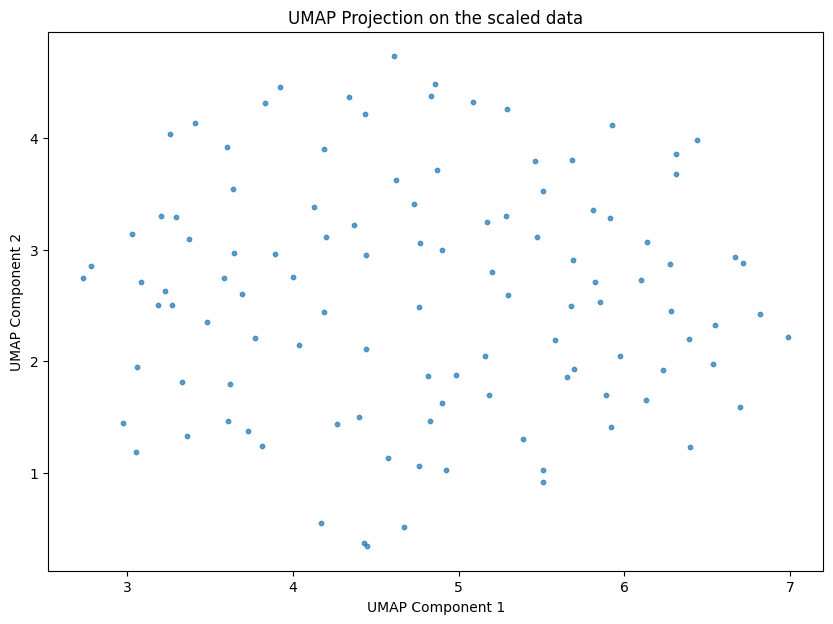

In [478]:
#conduct UMAP on the scaled features
from umap import UMAP
import matplotlib.pyplot as plt

umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)

# Transform the data with UMAP
features_umap = umap.fit_transform(features_scaled)

# Plot UMAP result
plt.figure(figsize=(10, 7))
plt.scatter(features_umap[:, 0], features_umap[:, 1], s=10, alpha=0.7)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Projection on the scaled data')
plt.show()



Next, we applied UMAP to the top 34 principle components of the PCA analysis. Note that the top 34 principle components can explain 80% of the variance. However, we did not find any clear clustering pattern with UMAP projections under various settings. An example of UMAP results is shown below with n_neighbors=15, minimum distance 0.1 and n_componenets 2.


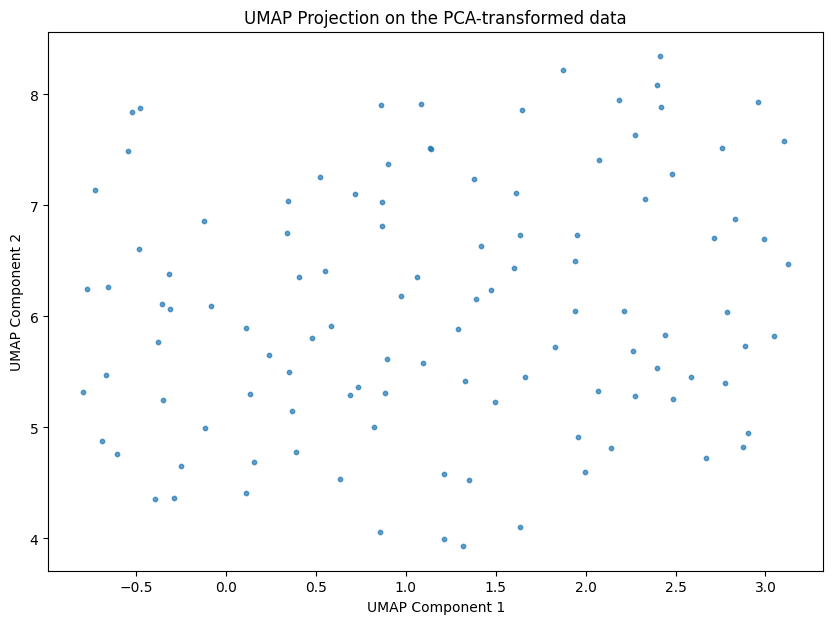

In [ ]:
#apply UMAP to the top 34 PC components

# Apply PCA to the scaled features
pca = PCA(n_components=34)
features_pca = pca.fit_transform(features_scaled)

# Transform the PCA features with UMAP
umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
features_pca_umap = umap.fit_transform(features_pca)

plt.figure(figsize=(10, 7))
plt.scatter(features_pca_umap[:, 0], features_pca_umap[:, 1], s=10, alpha=0.7)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Projection on the PCA-transformed data')
plt.show()


### K-means clustering

K-Means Clustering: This is one of the most widely used clustering algorithms. It’s fast and effective for datasets with spherical clusters. We use Silhouette Score to evaluate the quality of clusters and choose the optimal number of clusters.



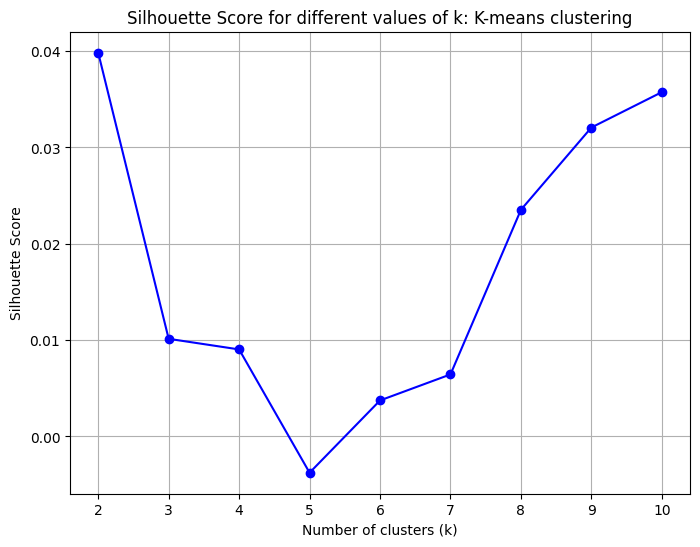

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
K = range(2, 11)  
# List to store the silhouette scores for each k
silhouette_scores = []

# Loop over different values of k
for k in K:
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(features_scaled) 
    # Calculate the silhouette score
    silhouette_avg = silhouette_score(features_scaled, cluster_labels)
    
    # Store the silhouette score
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(K, silhouette_scores, 'bo-', color='blue')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for different values of k: K-means clustering')
plt.grid(True)
plt.show()


Apparently, the otpimal number of clusters is 2. We then visualize the clustering results using PCA.

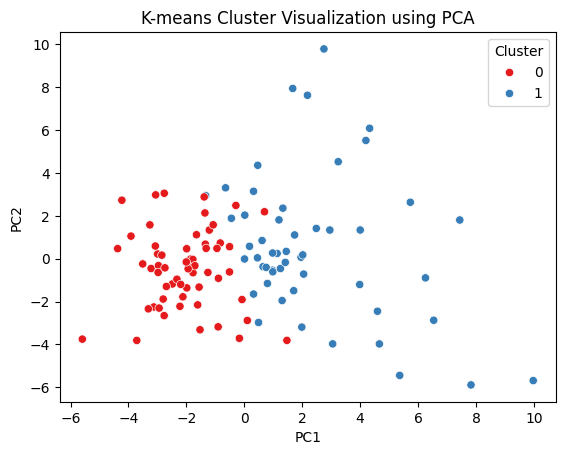

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

optimal_k = 2  
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels_kmeans = kmeans.fit_predict(features_scaled)

cluster_labels = cluster_labels_kmeans

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(features_scaled)

reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
reduced_df['Cluster'] = cluster_labels

# Plot the clusters
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=reduced_df, palette='Set1')
plt.title('K-means Cluster Visualization using PCA')
plt.show()


The result shows that the first two principal components capture enough of the structure in the data to make the clusters distinguishable.
It denotes that the The K-Means clusters align well with the directions of greatest variance (PC1 and PC2).

We then try to interpret and analyze how clusters from K-Means clustering relate to clinical, genotype and antibody data.

In [ ]:
import pandas as pd


features_columns = features.columns  
features_genotype = pd.DataFrame(features_scaled[:, :216], columns=features_columns[:216])
features_genotype['Cluster'] = cluster_labels  # Add the cluster labels

features_clinical = pd.DataFrame(features_scaled[:, 216:228], columns=features_columns[216:228])
features_clinical['Cluster'] = cluster_labels  # Add the cluster labels

features_antibody = pd.DataFrame(features_scaled[:, 228:], columns=features_columns[228:])
features_antibody['Cluster'] = cluster_labels  # Add the cluster labels




For clinical data, we first show summary statistics (e.g., mean) for features within each cluster. 

Note that the differences between cluster_sex is due to the imbalance sample observations of male versus female, i.e. there is only 1 male subject in the current batch of genotype data.



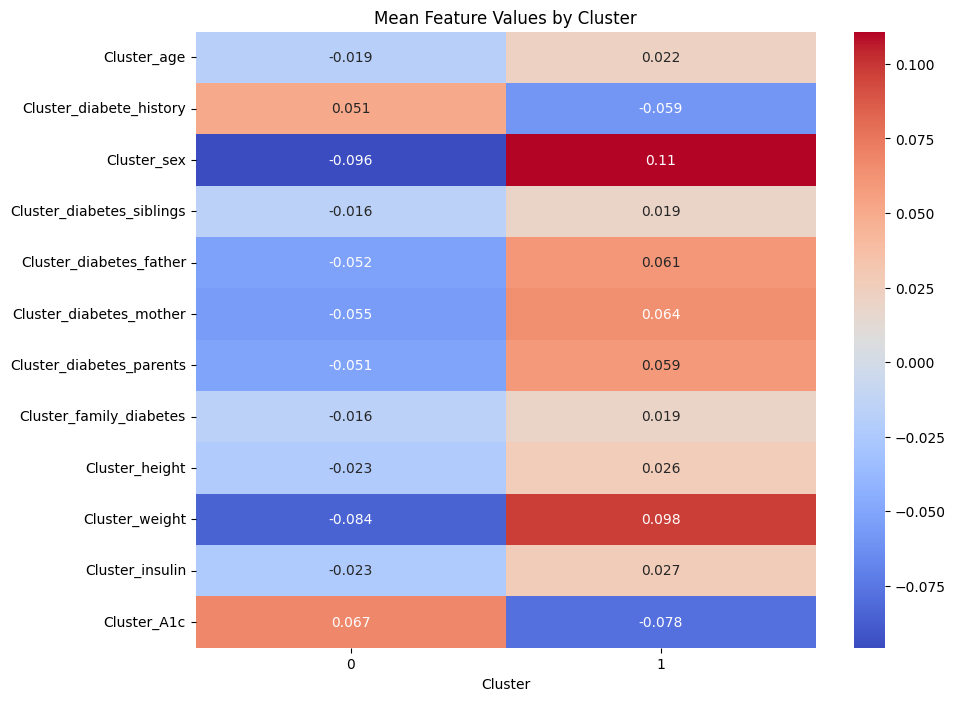

In [ ]:
import seaborn as sns

cluster_summary = features_clinical.groupby('Cluster').mean()


# Create a heatmap of mean feature values for each cluster
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_summary.T, cmap='coolwarm', annot=True)
plt.title('Mean Feature Values by Cluster')
plt.show()


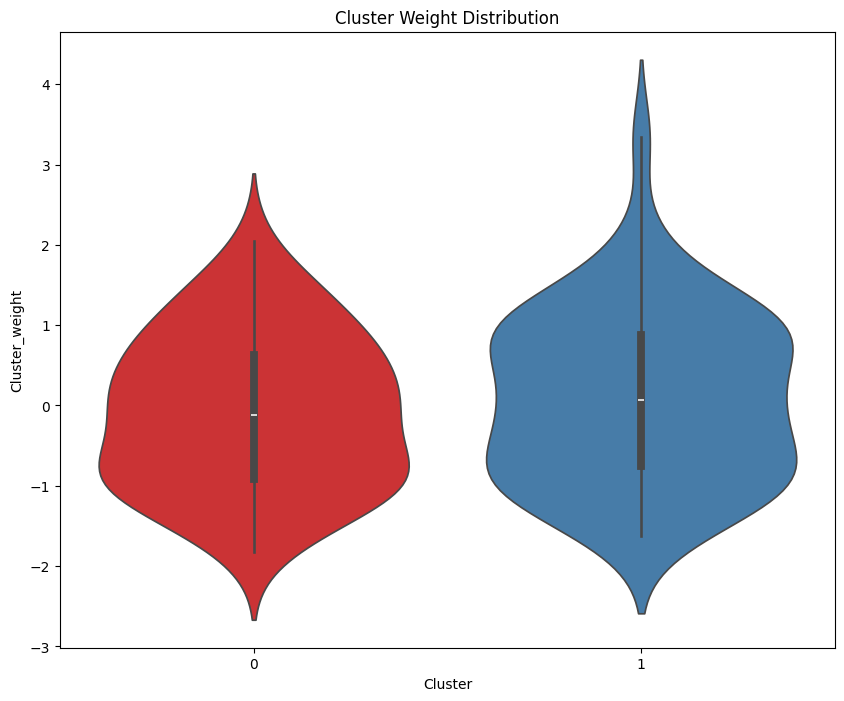

Cluster Sex Count:
Cluster_sex
-0.095783     109
 10.440307      1
Name: count, dtype: int64


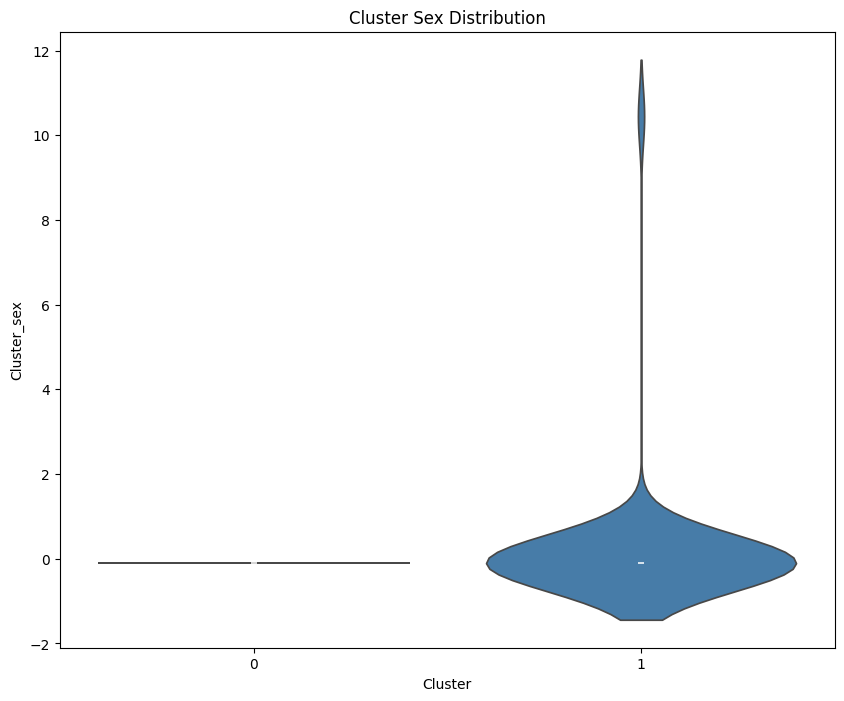

In [ ]:



plt.figure(figsize=(10, 8))
sns.violinplot(x='Cluster', y='Cluster_weight', data=features_clinical, palette='Set1')
plt.title('Cluster Weight Distribution')
plt.show()


cluster_sex_count = features_clinical['Cluster_sex'].value_counts()

print("Cluster Sex Count:")
print(cluster_sex_count)

      
plt.figure(figsize=(10, 8))
sns.violinplot(x='Cluster', y='Cluster_sex', data=features_clinical, palette='Set1')
plt.title('Cluster Sex Distribution')
plt.show()


We then examine the statistical significance of each feature in the clinical data between clusters. We use ANOVA tests to compare the means of each feature between clusters. The p-values are shown below. Note that the p-values are not corrected for multiple testing.


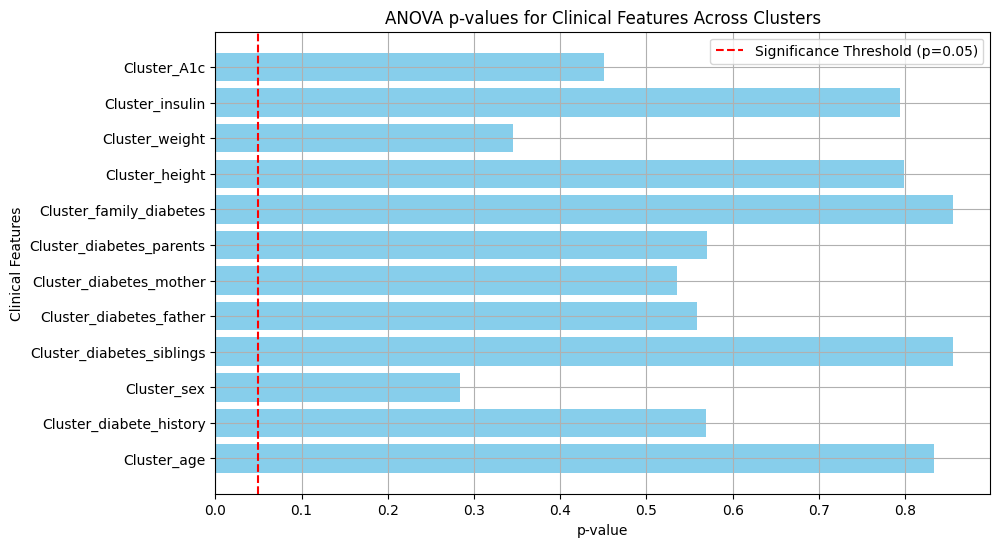

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

clinical_features = features_clinical.drop(columns=['Cluster'])
cluster_labels = features_clinical['Cluster']

p_values = []

for column in clinical_features.columns:
    groups = [clinical_features[cluster_labels == c][column] for c in np.unique(cluster_labels)]
    _, p_value = f_oneway(*groups)  # f_oneway returns the F-statistic and p-value
    p_values.append(p_value)

p_values_df = pd.DataFrame({'Feature': clinical_features.columns, 'p-value': p_values})

plt.figure(figsize=(10, 6))
plt.barh(p_values_df['Feature'], p_values_df['p-value'], color='skyblue')
plt.xlabel('p-value')
plt.ylabel('Clinical Features')
plt.title('ANOVA p-values for Clinical Features Across Clusters')
plt.axvline(x=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')
plt.legend()
plt.grid(True)
plt.show()



Note that the association between clinical features and the cluster membership is not statistically significant. 


Next, we examine the statistical significance of each feature in the genotype data between clusters. We use ANOVA tests to compare the means of each feature between clusters. The p-values are shown below. Note that the p-values are corrected for multiple testing with Bonferroni correction.

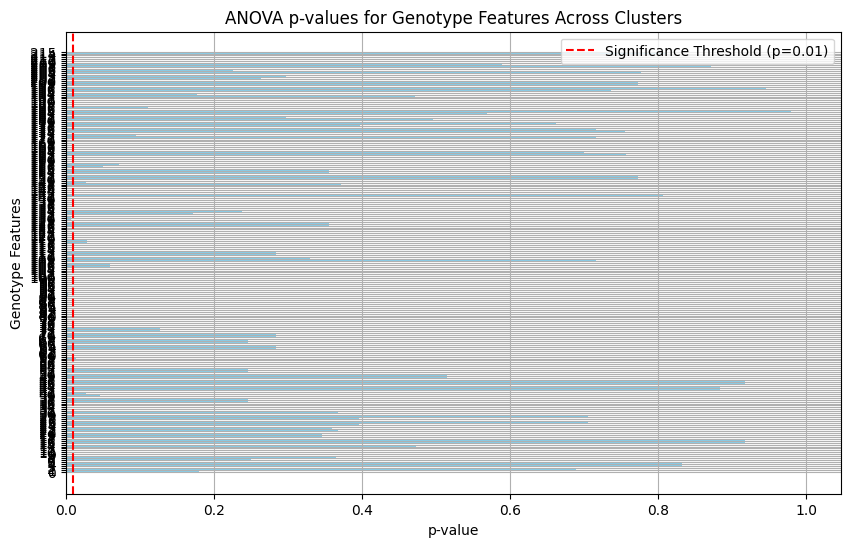

Genotype features with p-value < 0.01 after Bonferroni correction:
60      60
61      61
87      87
88      88
96      96
97      97
160    160
Name: Feature, dtype: object


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

import warnings
warnings.filterwarnings("ignore")

genotype_features = features_genotype.drop(columns=['Cluster'])
cluster_labels = features_genotype['Cluster']

p_values_genotype = []

for column in genotype_features.columns:
    groups = [genotype_features[cluster_labels == c][column] for c in np.unique(cluster_labels)]
    _, p_value = f_oneway(*groups)  # f_oneway returns the F-statistic and p-value
    p_values_genotype.append(p_value)

p_values_genotype_df = pd.DataFrame({'Feature': genotype_features.columns, 'p-value': p_values_genotype})

plt.figure(figsize=(10, 6))
plt.barh(p_values_genotype_df['Feature'], p_values_genotype_df['p-value'], color='skyblue')
plt.xlabel('p-value')
plt.ylabel('Genotype Features')
plt.title('ANOVA p-values for Genotype Features Across Clusters')
plt.axvline(x=0.01, color='red', linestyle='--', label='Significance Threshold (p=0.01)')
plt.legend()
plt.grid(True)
plt.show()

significant_genotype_features = p_values_genotype_df[p_values_genotype_df['p-value'] < 0.01/216]

print("Genotype features with p-value < 0.01 after Bonferroni correction:")
print(significant_genotype_features['Feature'])



As a result, we found these SNPs corresponds to the features with the most significant p-values in the t-tests:

In [ ]:
import warnings
warnings.filterwarnings("ignore")

significant_genotype_features['Feature'] = significant_genotype_features['Feature'].astype(int)

significant_genotype_features['SNP'] = significant_genotype_features['Feature'].apply(lambda x: (x // 3) + 1)

significant_snps = significant_genotype_features['SNP'].drop_duplicates()

print("Significant SNPs corresponding to p-value < 0.01:")
print(significant_snps)

print(bim.loc[significant_snps - 1])


Significant SNPs corresponding to p-value < 0.01:
60     21
87     30
96     33
160    54
Name: SNP, dtype: int64
   chrom                snp   cm       pos a0 a1   i
20     6  chr6:32479411:T:A  0.0  32479411  A  T  20
29     6  chr6:32655446:A:C  0.0  32655446  C  A  29
32     6  chr6:32658707:T:C  0.0  32658707  C  T  32
53    11  chr11:2159830:T:G  0.0   2159830  T  G  53


In fact, these SNPs that are associated with the clusters identified in the K-means clustering analysis are from MHC region and the INS gene.

NOte that the chr11:2159830:T:G is near the INS (insulin) gene, which encodes insulin, a key hormone that regulates glucose metabolism. Variants in and around this gene can be associated with diseases like diabetes, particularly Type 1 diabetes due to its critical role in blood sugar regulation.
 

Finally, we explore the relationship between the clusters and the antibody levels.  We first show  the p-values from ANOVA test for each feature in the antibody profiles between clusters.


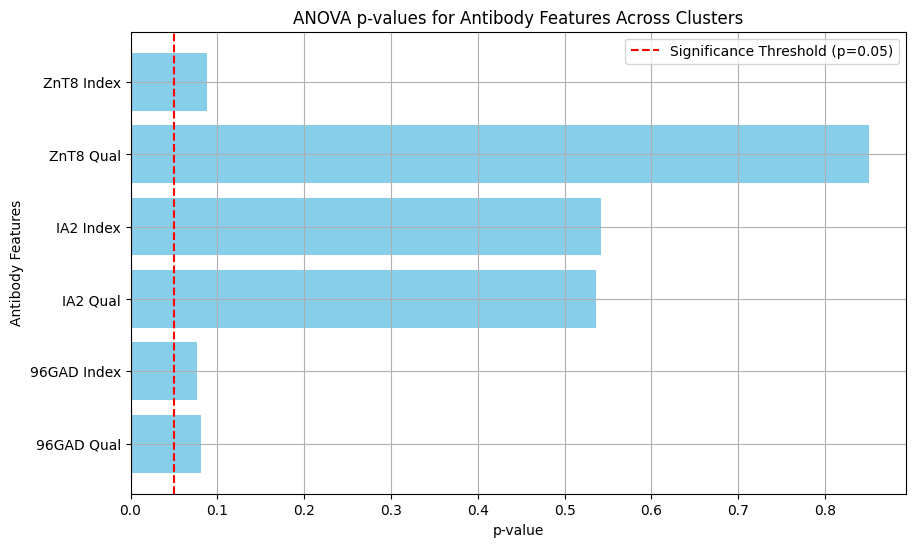

Antibody features with p-value < 0.05:
Series([], Name: Feature, dtype: object)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

antibody_features = features_antibody.drop(columns=['Cluster'])
cluster_labels = features_antibody['Cluster']

p_values_antibody = []

for column in antibody_features.columns:
    groups = [antibody_features[cluster_labels == c][column] for c in np.unique(cluster_labels)]
    _, p_value = f_oneway(*groups)  # f_oneway returns the F-statistic and p-value
    p_values_antibody.append(p_value)

p_values_antibody_df = pd.DataFrame({'Feature': antibody_features.columns, 'p-value': p_values_antibody})

# Plot the p-values
plt.figure(figsize=(10, 6))
plt.barh(p_values_antibody_df['Feature'], p_values_antibody_df['p-value'], color='skyblue')
plt.xlabel('p-value')
plt.ylabel('Antibody Features')
plt.title('ANOVA p-values for Antibody Features Across Clusters')
plt.axvline(x=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')
plt.legend()
plt.grid(True)
plt.show()

significant_antibody_features = p_values_antibody_df[p_values_antibody_df['p-value'] < 0.05]

print("Antibody features with p-value < 0.05:")
print(significant_antibody_features['Feature'])


Note that the associations between the clusters and the antibody levels are not significant.

We then plot the boxplot of the antibody features for each cluster.

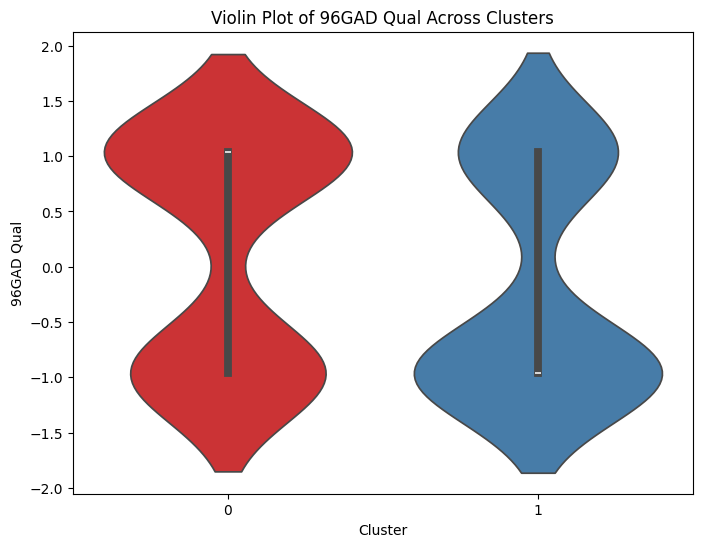

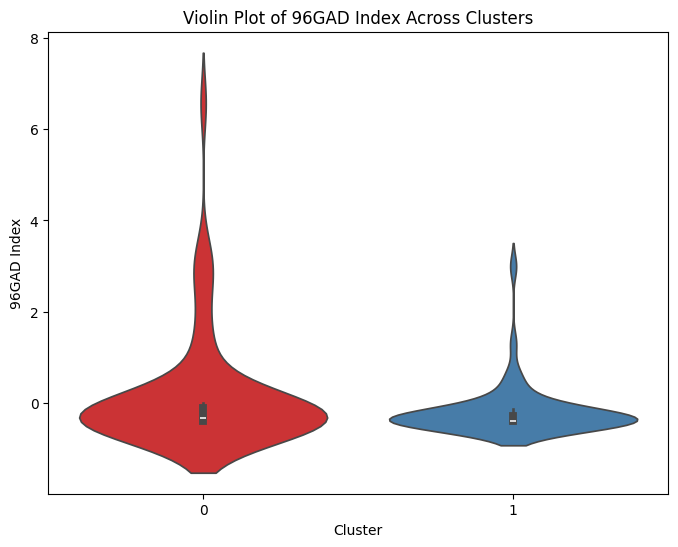

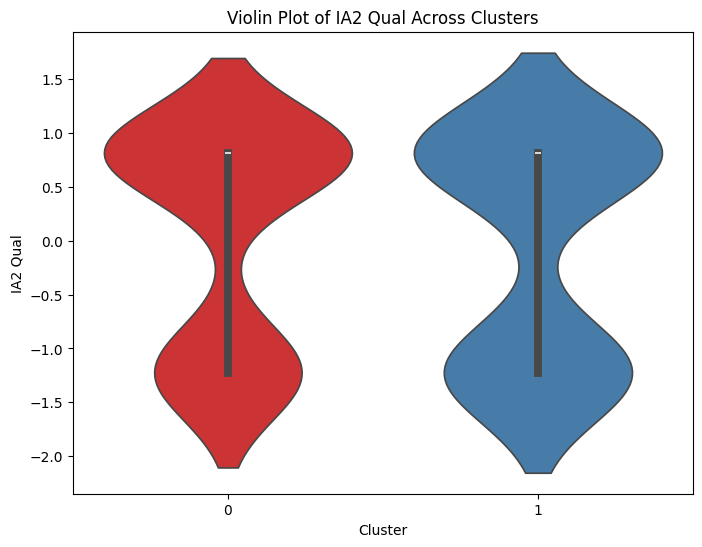

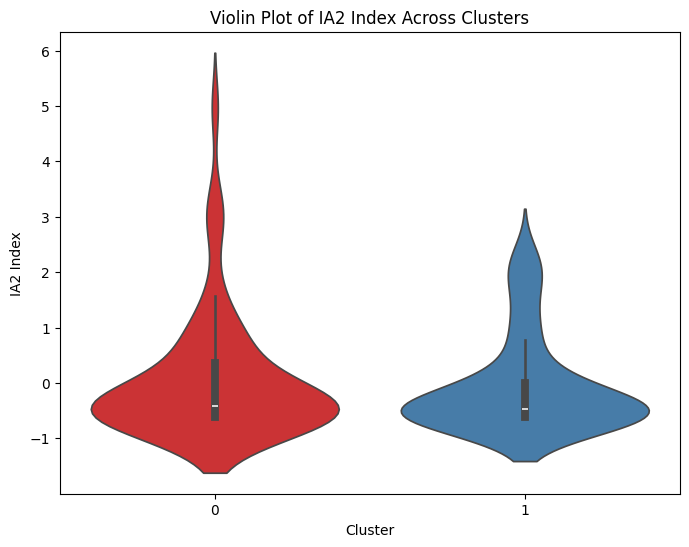

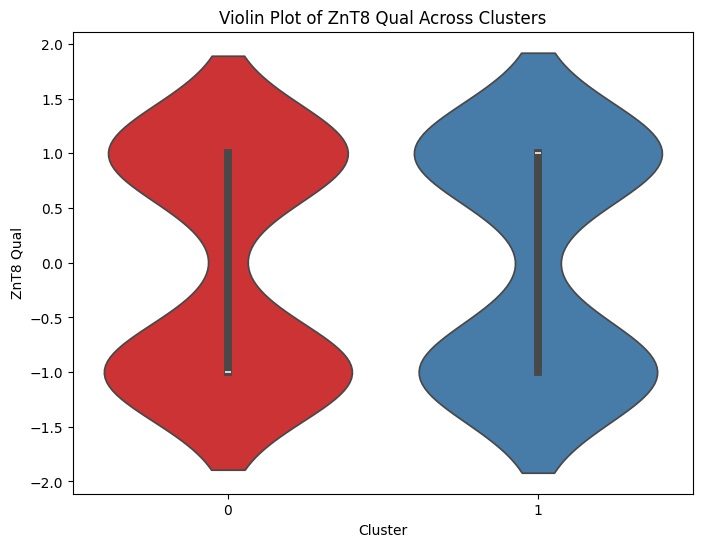

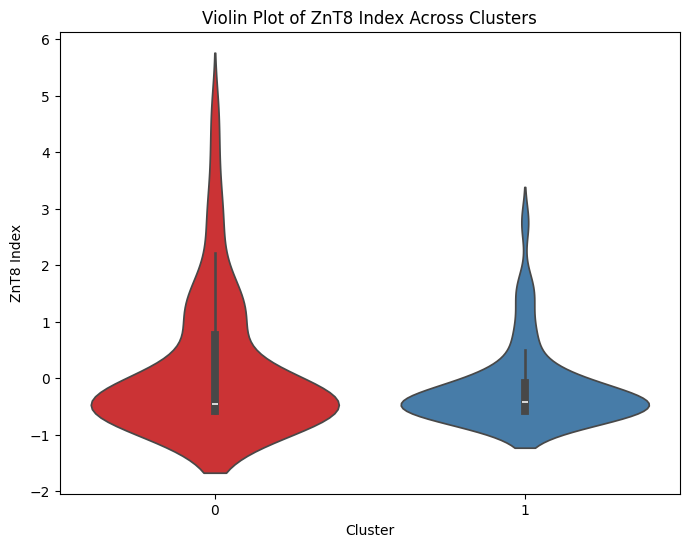

In [ ]:

import warnings
warnings.filterwarnings("ignore")
for column in antibody_features.columns:
    plt.figure(figsize=(8, 6))
    sns.violinplot(x='Cluster', y=column, data=features_antibody, palette='Set1')
    plt.title(f'Violin Plot of {column} Across Clusters')
    plt.show()
    



In conclusion, the associations between the clusters and the antibody levels are not significant. 
However, we do see decreased level of antibody in cluster 2 compared to cluster 1, across three types of antibody. However, the differences are not statistically significant.

### Hierarchical clustering

We then try the hierarchical clustering and find the optimal number of clusters with the dendrogram.

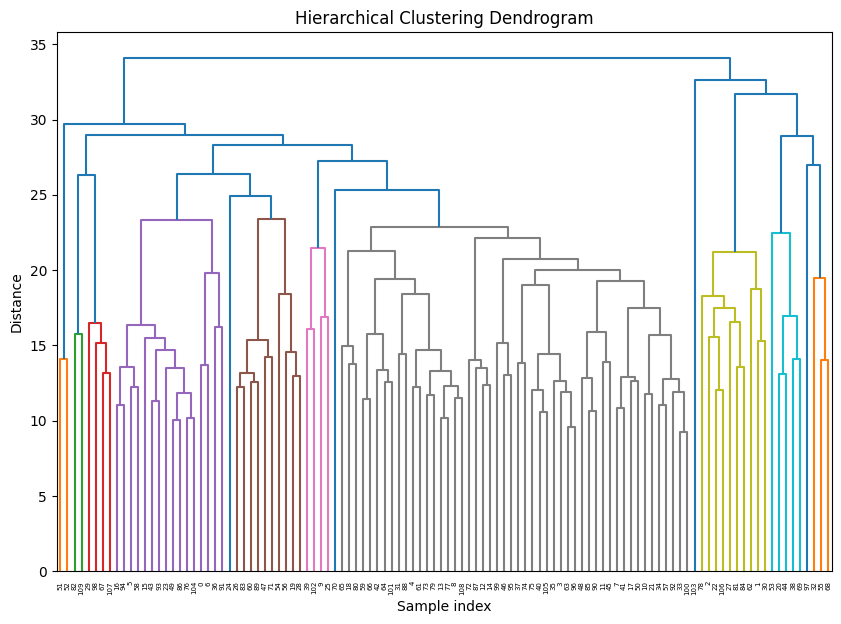

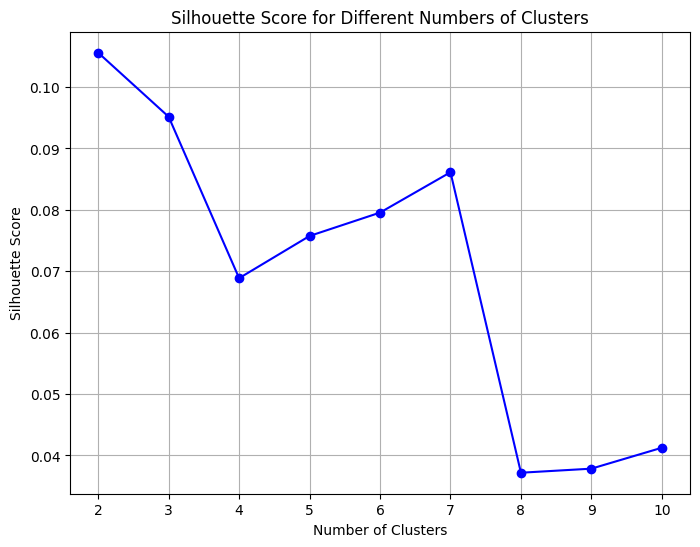

The optimal number of clusters is: 2


In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Perform hierarchical clustering using AgglomerativeClustering
linkage_matrix = linkage(features_scaled, method='ward')

# Step 2: Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

# Step 3: Compute Agglomerative Clustering with different numbers of clusters
range_n_clusters = range(2, 11)
silhouette_scores = []

for n_clusters in range_n_clusters:
    agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = agglomerative_clustering.fit_predict(features_scaled)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(features_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Step 4: Plot the silhouette scores for different numbers of clusters
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.grid(True)
plt.show()

# Step 5: Identify the optimal number of clusters (maximum silhouette score)
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"The optimal number of clusters is: {optimal_n_clusters}")


We then visualize the HC clustering results using PCA to see if the clusters are distinguishable with respect to PCA. The result below shows the HC clustering membership versus the first two principle components of the PCA analysis. We also present the cross-table of HC clustering membership versus the K-means clustering membership. The result shows that these two clustering memberships captured different patterns in the data.

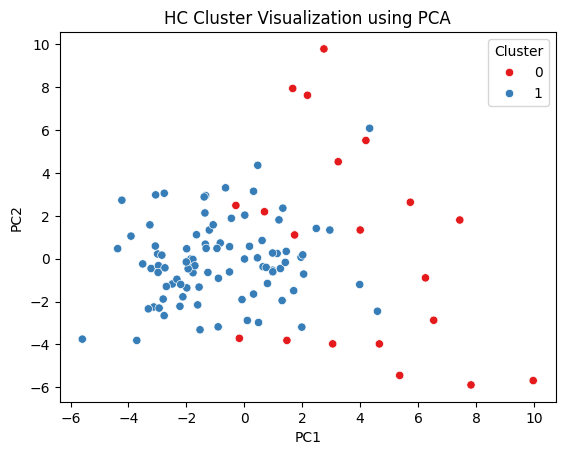

Contingency Table of K-Means and HC Clusters:
HC Clusters        0   1
K-Means Clusters        
0                  4  55
1                 16  35


In [ ]:
#now calculate the HC clustering IDs according to the optimal number of clusters

# Perform Agglomerative Clustering with the optimal number of clusters
agglomerative_clustering = AgglomerativeClustering(n_clusters=optimal_n_clusters)
cluster_labels_hc = agglomerative_clustering.fit_predict(features_scaled)



# Create a DataFrame for visualization
reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
reduced_df['Cluster'] = cluster_labels_hc

# Plot the clusters
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=reduced_df, palette='Set1')
plt.title('HC Cluster Visualization using PCA')
plt.show()

#now plot the table of cluster_labels_hc versus cluster_labels
comparison_df = pd.DataFrame({'K-Means Clusters': cluster_labels_kmeans, 'HC Clusters': cluster_labels_hc})
print("Contingency Table of K-Means and HC Clusters:")
print(pd.crosstab(comparison_df['K-Means Clusters'], comparison_df['HC Clusters']))



We then explore the relationship between the HC clusters and the clinical, genotype, and antibody data.

The associations between the clusters and the clinical features are not significant as shown below.

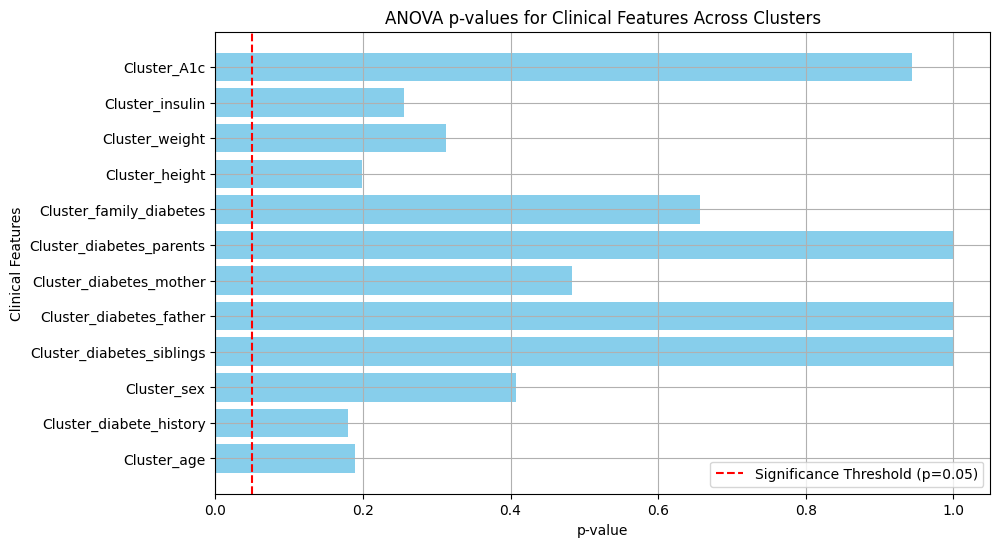

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency

clinical_features = features_clinical.drop(columns=['Cluster'])
cluster_labels = cluster_labels_hc


results = []

for column in clinical_features.columns:
    unique_values = clinical_features[column].nunique()
    
    if unique_values == 2:  # Binary feature
        contingency_table = pd.crosstab(cluster_labels, clinical_features[column])
        _, p_value, _, _ = chi2_contingency(contingency_table)
        results.append({'Feature': column, 'p-value': p_value, 'Test': 'Chi-square'})
    else:  # Continuous feature
        # Perform ANOVA across clusters
        groups = [clinical_features[cluster_labels == c][column] for c in np.unique(cluster_labels)]
        _, p_value = f_oneway(*groups)
        results.append({'Feature': column, 'p-value': p_value, 'Test': 'ANOVA'})

p_values_df = pd.DataFrame(results)


plt.figure(figsize=(10, 6))
plt.barh(p_values_df['Feature'], p_values_df['p-value'], color='skyblue')
plt.xlabel('p-value')
plt.ylabel('Clinical Features')
plt.title('ANOVA p-values for Clinical Features Across Clusters')
plt.axvline(x=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')
plt.legend()
plt.grid(True)
plt.show()





Furthermore, we explore the relationship between the HC clusters and the genotype data.


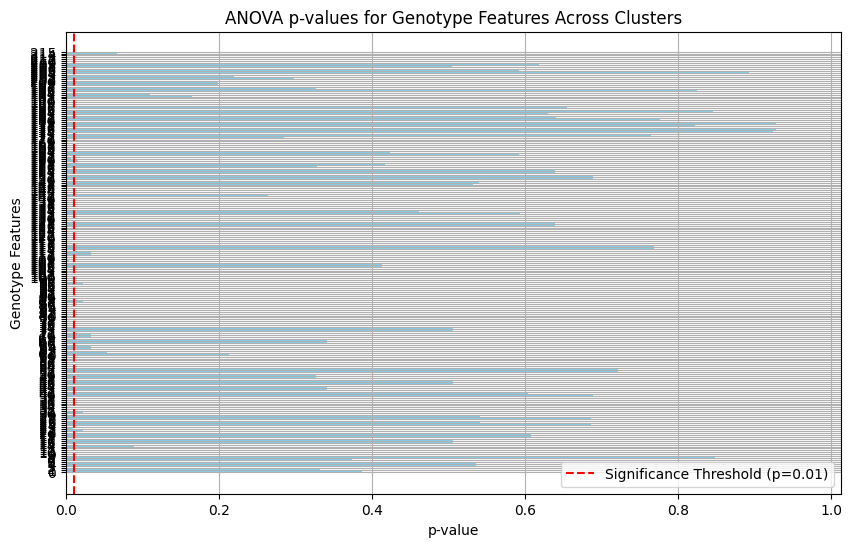

Genotype features with p-value < 0.01 after Bonferroni correction:
36      36
37      37
75      75
76      76
90      90
91      91
99      99
100    100
117    117
118    118
Name: Feature, dtype: object


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

import warnings
warnings.filterwarnings("ignore")

genotype_features = features_genotype.drop(columns=['Cluster'])
cluster_labels = cluster_labels_hc

p_values_genotype = []

for column in genotype_features.columns:
    groups = [genotype_features[cluster_labels == c][column] for c in np.unique(cluster_labels)]
    _, p_value = f_oneway(*groups)  # f_oneway returns the F-statistic and p-value
    p_values_genotype.append(p_value)

p_values_genotype_df = pd.DataFrame({'Feature': genotype_features.columns, 'p-value': p_values_genotype})

# Plot the p-values
plt.figure(figsize=(10, 6))
plt.barh(p_values_genotype_df['Feature'], p_values_genotype_df['p-value'], color='skyblue')
plt.xlabel('p-value')
plt.ylabel('Genotype Features')
plt.title('ANOVA p-values for Genotype Features Across Clusters')
plt.axvline(x=0.01, color='red', linestyle='--', label='Significance Threshold (p=0.01)')
plt.legend()
plt.grid(True)
plt.show()

significant_genotype_features = p_values_genotype_df[p_values_genotype_df['p-value'] < 0.01/216]

print("Genotype features with p-value < 0.01 after Bonferroni correction:")
print(significant_genotype_features['Feature'])


We then look into the SNPs that are associated with the clusters identified in the HC clustering analysis.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

significant_genotype_features['Feature'] = significant_genotype_features['Feature'].astype(int)

significant_genotype_features['SNP'] = significant_genotype_features['Feature'].apply(lambda x: (x // 3) + 1)

significant_snps = significant_genotype_features['SNP'].drop_duplicates()

print("Significant SNPs corresponding to p-value < 0.01:")
print(significant_snps)

print(bim.loc[significant_snps - 1])


Significant SNPs corresponding to p-value < 0.01:
36     13
75     26
90     31
99     34
117    40
Name: SNP, dtype: int64
   chrom                 snp   cm       pos  a0 a1   i
12     6  chr6:31307016:G:GC  0.0  31307016  GC  G  12
25     6   chr6:32634974:C:A  0.0  32634974   A  C  25
30     6   chr6:32658260:G:T  0.0  32658260   T  G  30
33     6   chr6:32659936:G:A  0.0  32659936   A  G  33
39     6   chr6:32712215:C:T  0.0  32712215   T  C  39


Apparently, all those significant SNPs are from the MHC region.

Finally, we explore the relationship between the HC clusters and the antibody levels. No significant associations found under pvalue < 0.05 after bonferroni correction. Note that ZnT8 antibody levels have univariate t-test pvalue = 0.028, but not significant under multiple testing threshold  0.05/6 = 0.0083.

       Feature   p-value
0   96GAD Qual  0.422828
1  96GAD Index  0.942687
2     IA2 Qual  0.617686
3    IA2 Index  0.497226
4    ZnT8 Qual  0.140559
5   ZnT8 Index  0.028284


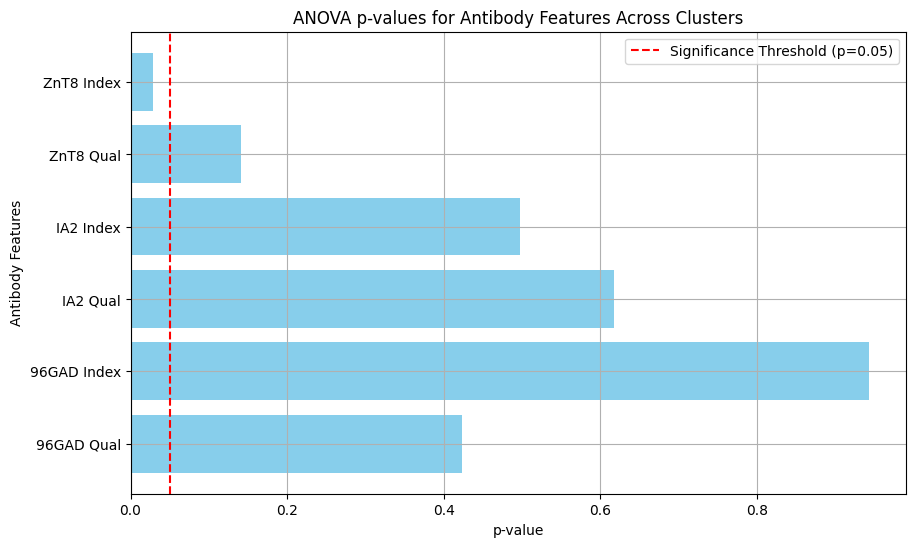

Antibody features with p-value < 0.05:
5    ZnT8 Index
Name: Feature, dtype: object


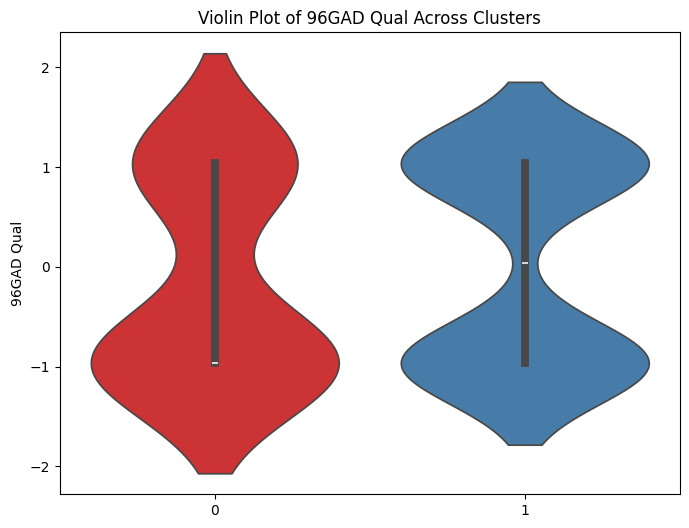

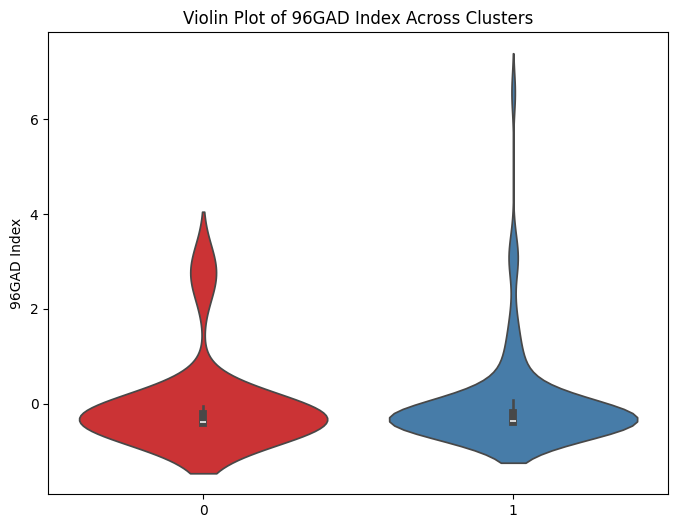

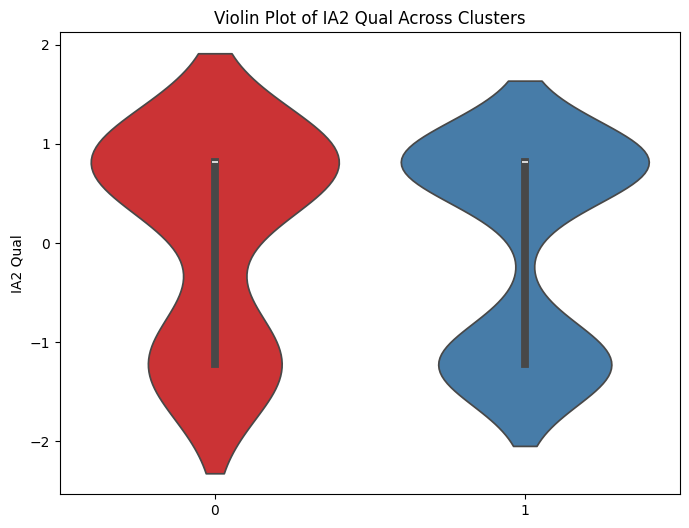

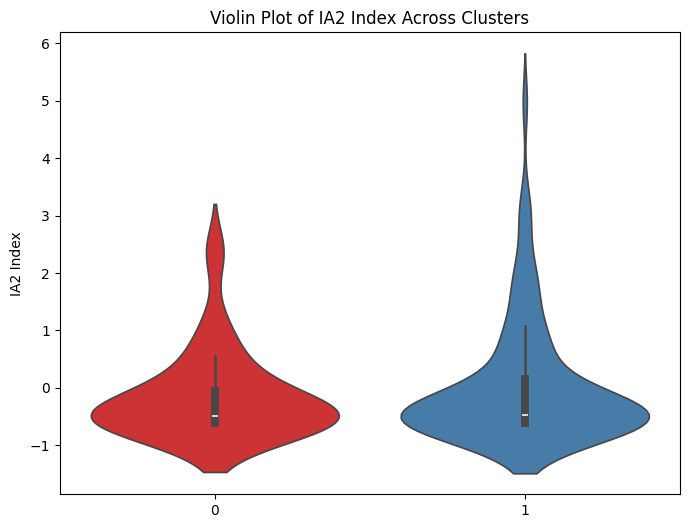

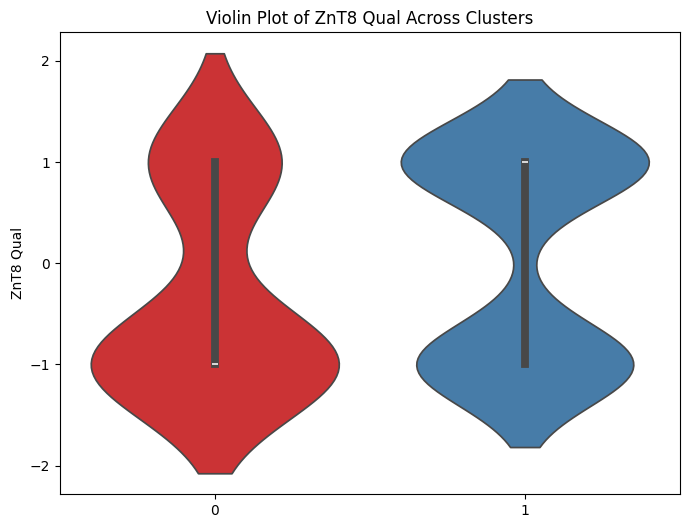

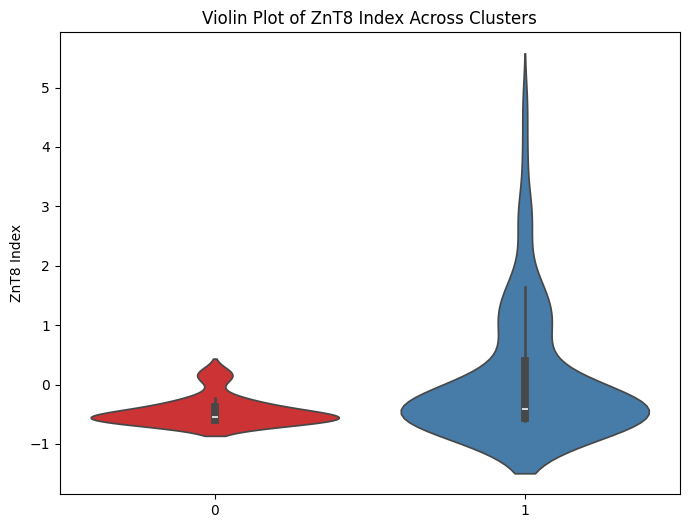

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

antibody_features = features_antibody.drop(columns=['Cluster'])
cluster_labels = cluster_labels_hc

p_values_antibody = []

for column in antibody_features.columns:
    groups = [antibody_features[cluster_labels == c][column] for c in np.unique(cluster_labels)]
    _, p_value = f_oneway(*groups)  # f_oneway returns the F-statistic and p-value
    p_values_antibody.append(p_value)

p_values_antibody_df = pd.DataFrame({'Feature': antibody_features.columns, 'p-value': p_values_antibody})

print(p_values_antibody_df)


# Plot the p-values
plt.figure(figsize=(10, 6))
plt.barh(p_values_antibody_df['Feature'], p_values_antibody_df['p-value'], color='skyblue')
plt.xlabel('p-value')
plt.ylabel('Antibody Features')
plt.title('ANOVA p-values for Antibody Features Across Clusters')
plt.axvline(x=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')
plt.legend()
plt.grid(True)
plt.show()

significant_antibody_features = p_values_antibody_df[p_values_antibody_df['p-value'] < 0.05]

# Print the features with p-value < 0.05
print("Antibody features with p-value < 0.05:")
print(significant_antibody_features['Feature'])



import warnings
warnings.filterwarnings("ignore")
for column in antibody_features.columns:
    plt.figure(figsize=(8, 6))
    sns.violinplot(x=cluster_labels_hc, y=column, data=features_antibody, palette='Set1')
    plt.title(f'Violin Plot of {column} Across Clusters')
    plt.show()
    

In conclusion, the HC clustering results were largely driven by MHC region SNPs and ZnT8 antibody levels.

## Soft-threshold Clustering

### Fuzzy C-Means Clustering

* Soft Clustering: Instead of assigning each point to a single cluster, FCM computes membership probabilities for each point across all clusters. This is useful when there are no clear boundaries between clusters.

* Membership Matrix: FCM outputs a membership matrix where each data point has a numerical membership value every cluster, instead of categorical clsuter assignments.

* Flexibility: Points that are in overlapping regions between clusters will have high membership in multiple clusters.

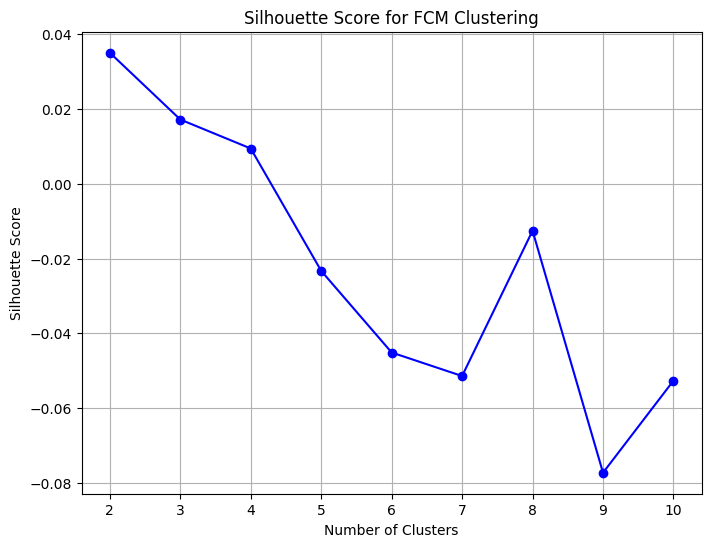

The optimal number of clusters is: 2


In [ ]:
# pip install fuzzy-c-means

import numpy as np
import matplotlib.pyplot as plt
from fcmeans import FCM
from sklearn.metrics import silhouette_score
import pandas as pd

features_scaled_dat = pd.read_csv('results/scaled_features.csv')

features_scaled = features_scaled_dat.values  # Converts DataFrame to NumPy array



#set a random seed
np.random.seed(42)

range_n_clusters = range(2, 11)
silhouette_scores = []

# Loop over different numbers of clusters
for n_clusters in range_n_clusters:
    # Step 1: Perform Fuzzy C-Means clustering
    fcm = FCM(n_clusters=n_clusters)
    fcm.fit(features_scaled)
    
    # Step 2: Convert soft memberships to hard labels by taking the highest membership value
    fcm_labels = fcm.predict(features_scaled)  # Hard cluster labels
    
    # Step 3: Calculate silhouette score based on hard labels
    silhouette_avg = silhouette_score(features_scaled, fcm_labels)
    silhouette_scores.append(silhouette_avg)

# Step 4: Plot silhouette scores to find the optimal number of clusters
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for FCM Clustering')
plt.grid(True)
plt.show()

# Step 5: Find the optimal number of clusters (maximum silhouette score)
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"The optimal number of clusters is: {optimal_n_clusters}")


We conducted Fuzzy C-Means clustering on the data with the optimal number of clusters = 2. Note that to achive stable clustering results we repeated FCM multiple times (N=50) and averaged the results for more stable outcomes. We then visualize the clustering results using PCA.

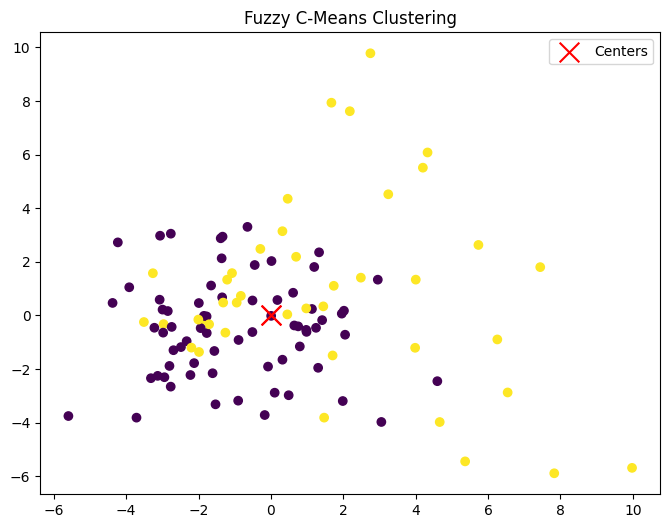

Membership values for first few points:
[[0.50000005 0.49999995]
 [0.49999982 0.50000018]
 [0.49999979 0.50000021]
 [0.50000006 0.49999994]
 [0.50000003 0.49999997]]


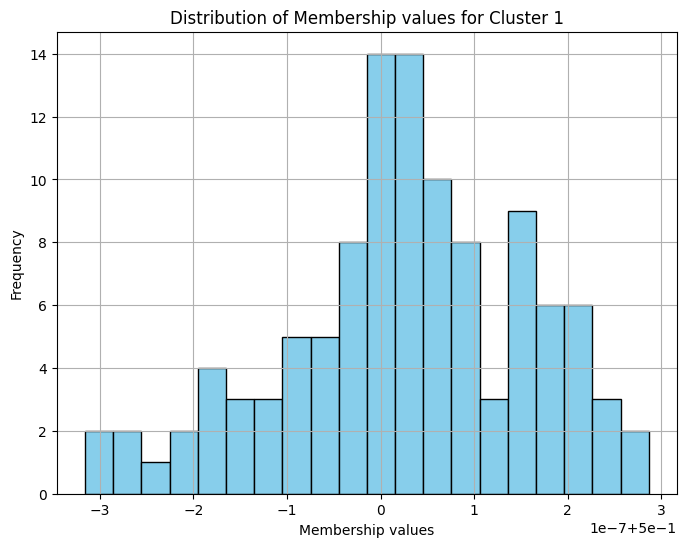

In [ ]:
# pip install fuzzy-c-means

import numpy as np
import matplotlib.pyplot as plt
from fcmeans import FCM
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score


# Set a random seed globally
np.random.seed(42)

n_clusters = 2
best_labels = None
best_membership = None
best_silhouette = -1  # Start with a low silhouette score

# Run FCM multiple times
for _ in range(50):
    fcm = FCM(n_clusters=n_clusters)
    fcm.fit(features_scaled)
    fcm_labels = fcm.predict(features_scaled)
    current_membership = fcm.u  # Soft membership matrix
    fcm_centers = fcm.centers
    
    # Calculate silhouette score for evaluation
    silhouette_avg = silhouette_score(features_scaled, fcm_labels)
    
    # Update if this run has the best 
    if silhouette_avg > best_silhouette:
        best_silhouette = silhouette_avg
        best_labels = fcm_labels
        best_centers = fcm_centers
        best_membership = current_membership

# Assign the best membership matrix
membership_matrix = best_membership
fcm_labels = best_labels
fcm_centers = best_centers

# Step 3: Visualize the clustering using PCA (reduce to 2 components for visualization)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=fcm_labels, cmap='viridis')
plt.scatter(fcm_centers[:, 0], fcm_centers[:, 1], marker='x', s=200, color='red', label='Centers')
plt.title('Fuzzy C-Means Clustering')
plt.legend()
plt.show()

print("Membership values for first few points:")
print(membership_matrix[:5])

#plot the distribution of the first column of membership_matrix
plt.figure(figsize=(8, 6))
plt.hist(membership_matrix[:, 0], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Membership values')
plt.ylabel('Frequency')
plt.title('Distribution of Membership values for Cluster 1')
plt.grid(True)
plt.show()

#pd.DataFrame(membership_matrix).to_csv('results/fcm_membership.csv', index=False)

#membership_matrix = pd.read_csv('results/fcm_membership.csv').values


Note that the cluster centers from the FCM are largely overlapping on each other. It denotes the soft clustering nature of FCM and the lack of clear boundaries between the two clusters.

To proceed, we look into the associations between the FCM cluster values and the clinical, genotype, and antibody data.

Note that with soft-threshold clustering, the cluster membership is not a binary value, but a continuous value. Therefore we test the association between the cluster membership and the clinical, genotype, and antibody data with T-test.

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

np.random.seed(42)
clinical_features = features_clinical.drop(columns=['Cluster'])
cluster_labels_fcm = membership_matrix[:, 0]


p_values = []
r_squared = []

for column in clinical_features.columns:
    X = sm.add_constant(clinical_features[column])  # Add a constant (intercept term)
    model = sm.OLS(cluster_labels_fcm, X).fit()  # Fit the linear regression model
    p_values.append(model.pvalues[1])  # Store the p-value of the feature
    r_squared.append(model.rsquared)  # Store the R-squared value

regression_results = pd.DataFrame({
    'Feature': clinical_features.columns,
    'p-value': p_values,
    'R-squared': r_squared
})

print(regression_results)


                      Feature   p-value     R-squared
0                 Cluster_age  0.437028  5.603455e-03
1     Cluster_diabete_history  0.772567  7.767283e-04
2                 Cluster_sex  0.471874  4.803106e-03
3   Cluster_diabetes_siblings  0.701707  1.363725e-03
4     Cluster_diabetes_father  0.420564  6.016522e-03
5     Cluster_diabetes_mother  0.993884  5.465660e-07
6    Cluster_diabetes_parents  0.640050  2.032116e-03
7     Cluster_family_diabetes  0.808799  5.445181e-04
8              Cluster_height  0.488971  4.443905e-03
9              Cluster_weight  0.226918  1.349008e-02
10            Cluster_insulin  0.222708  1.373561e-02
11                Cluster_A1c  0.767655  8.116348e-04


The associations between the FCM clusters and the clinical features are not sigificant under pvalue < 0.05 after bonferroni correction.
For example, the scatterplot of the FCM clusters and the clinical weight and insulin dosages are shown below.

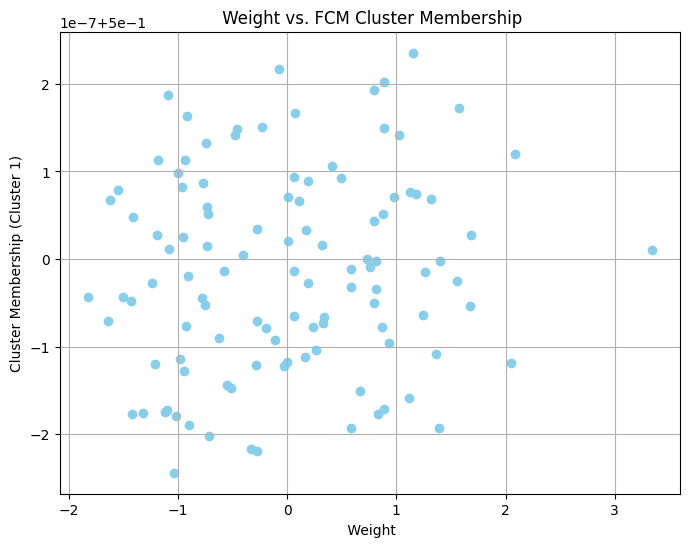

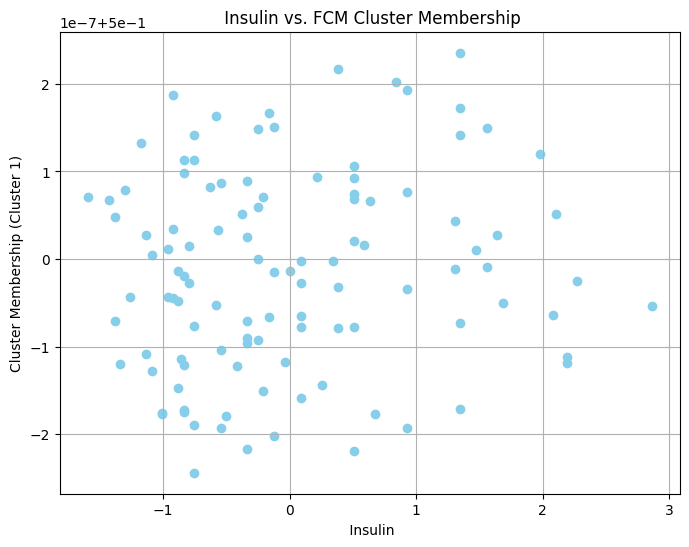

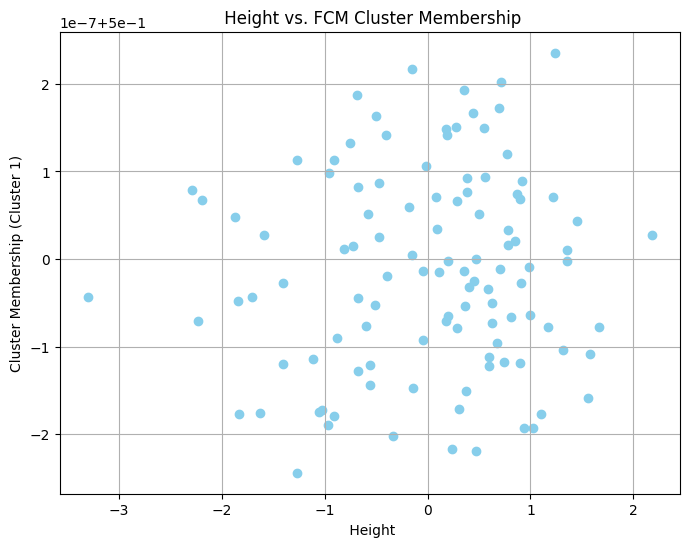

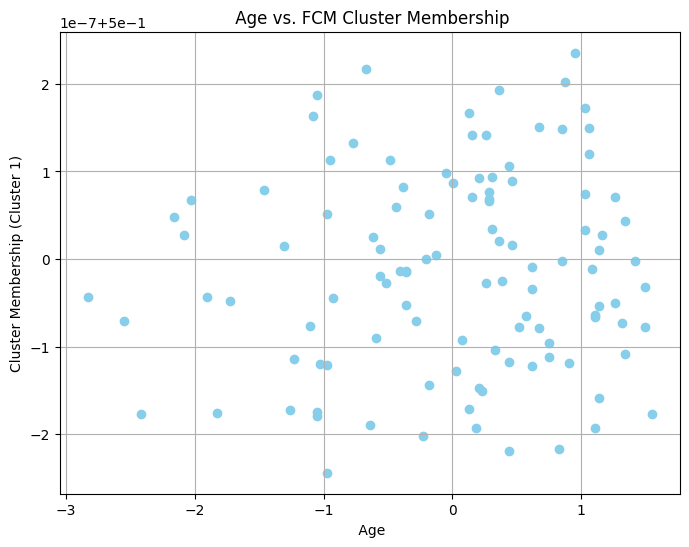

In [499]:
# plot the scatterplot of the Cluster_weight   versus the cluster_labels_fcm
plt.figure(figsize=(8, 6))
plt.scatter(features_clinical['Cluster_weight'], cluster_labels_fcm, color='skyblue')
plt.xlabel(' Weight')
plt.ylabel('Cluster Membership (Cluster 1)')
plt.title(' Weight vs. FCM Cluster Membership')
plt.grid(True)
plt.show()
# plot the scatterplot of the Cluster_insulin     versus the cluster_labels_fcm
plt.figure(figsize=(8, 6))
plt.scatter(features_clinical['Cluster_insulin'], cluster_labels_fcm, color='skyblue')
plt.xlabel(' Insulin')
plt.ylabel('Cluster Membership (Cluster 1)')
plt.title(' Insulin vs. FCM Cluster Membership')
plt.grid(True)
plt.show()
# plot the scatterplot of the Cluster_height     versus the cluster_labels_fcm
plt.figure(figsize=(8, 6))
plt.scatter(features_clinical['Cluster_height'], cluster_labels_fcm, color='skyblue')
plt.xlabel(' Height')
plt.ylabel('Cluster Membership (Cluster 1)')
plt.title(' Height vs. FCM Cluster Membership')
plt.grid(True)
plt.show()

# plot the scatterplot of the Cluster_age    versus the cluster_labels_fcm
plt.figure(figsize=(8, 6))
plt.scatter(features_clinical['Cluster_age'], cluster_labels_fcm, color='skyblue')
plt.xlabel(' Age')
plt.ylabel('Cluster Membership (Cluster 1)')
plt.title(' Age vs. FCM Cluster Membership')
plt.grid(True)
plt.show()




Next, we explore the relationship between the FCM clusters and the genotype data. We first show the genotype features with significant p-values under 0.05 after Bonferroni correction for multiple testing.

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

np.random.seed(42)

genotype_features = features_genotype.drop(columns=['Cluster'])
cluster_labels_fcm = membership_matrix[:, 0]


p_values = []
r_squared = []

for column in genotype_features.columns:
    X = sm.add_constant(genotype_features[column])  # Add a constant (intercept term)
    model = sm.OLS(cluster_labels_fcm, X).fit()  # Fit the linear regression model
    p_values.append(model.pvalues[1])  # Store the p-value of the feature
    r_squared.append(model.rsquared)  # Store the R-squared value

regression_results = pd.DataFrame({
    'Feature': genotype_features.columns,
    'p-value': p_values,
    'R-squared': r_squared
})

# Print the siginificant features with pvalue < 0.05/216
print("Genotype features with p-value < 0.05 after Bonferroni correction for multiple testing:")
print(regression_results[regression_results['p-value'] < 0.05/216])

 #filter the significant features with pvalue < 0.05/216
significant_genotype_features = regression_results[regression_results['p-value'] < 0.05/216]


Genotype features with p-value < 0.05 after Bonferroni correction for multiple testing:
    Feature       p-value  R-squared
60       60  1.188813e-11   0.348016
61       61  8.449016e-14   0.404298
87       87  1.339115e-14   0.424032
88       88  8.899290e-26   0.641066
96       96  1.339115e-14   0.424032
97       97  8.899290e-26   0.641066
114     114  3.603408e-07   0.214054
115     115  3.603408e-07   0.214054
159     159  8.317385e-09   0.265666
160     160  1.716618e-10   0.315558


In [ ]:
import warnings
warnings.filterwarnings("ignore")

significant_genotype_features['Feature'] = significant_genotype_features['Feature'].astype(int)

significant_genotype_features['SNP'] = significant_genotype_features['Feature'].apply(lambda x: (x // 3) + 1)

# Drop duplicate SNPs
significant_snps = significant_genotype_features['SNP'].drop_duplicates()

# Print the unique SNPs corresponding to significant genotype features
print("Significant SNPs corresponding to p-value < 0.05 after Bonfferoni correction:")
print(significant_snps)

print(bim.loc[significant_snps - 1])


Significant SNPs corresponding to p-value < 0.05 after Bonfferoni correction:
60     21
87     30
96     33
114    39
159    54
Name: SNP, dtype: int64
   chrom                snp   cm       pos a0 a1   i
20     6  chr6:32479411:T:A  0.0  32479411  A  T  20
29     6  chr6:32655446:A:C  0.0  32655446  C  A  29
32     6  chr6:32658707:T:C  0.0  32658707  C  T  32
38     6  chr6:32709663:G:A  0.0  32709663  A  G  38
53    11  chr11:2159830:T:G  0.0   2159830  T  G  53


The markers that are associated with the FCM clusters are from the MHC region and the INS (insulin) gene on chromosome 11. The INS gene is highly significant because it encodes insulin.

Finally, we explore the relationship between the FCM clusters and the antibody levels. No significant associations found under pvalue < 0.05 after bonferroni correction.

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

np.random.seed(42)

antibody_features = features_antibody.drop(columns=['Cluster'])
cluster_labels_fcm = membership_matrix[:, 0]


p_values = []
r_squared = []

for column in antibody_features.columns:
    X = sm.add_constant(antibody_features[column])  # Add a constant (intercept term)
    model = sm.OLS(cluster_labels_fcm, X).fit()  # Fit the linear regression model
    p_values.append(model.pvalues[1])  # Store the p-value of the feature
    r_squared.append(model.rsquared)  # Store the R-squared value

regression_results = pd.DataFrame({
    'Feature': antibody_features.columns,
    'p-value': p_values,
    'R-squared': r_squared
})

print(regression_results)


       Feature   p-value  R-squared
0   96GAD Qual  0.099623   0.024908
1  96GAD Index  0.358763   0.007804
2     IA2 Qual  0.701168   0.001369
3    IA2 Index  0.168393   0.017493
4    ZnT8 Qual  0.876767   0.000224
5   ZnT8 Index  0.047611   0.035840


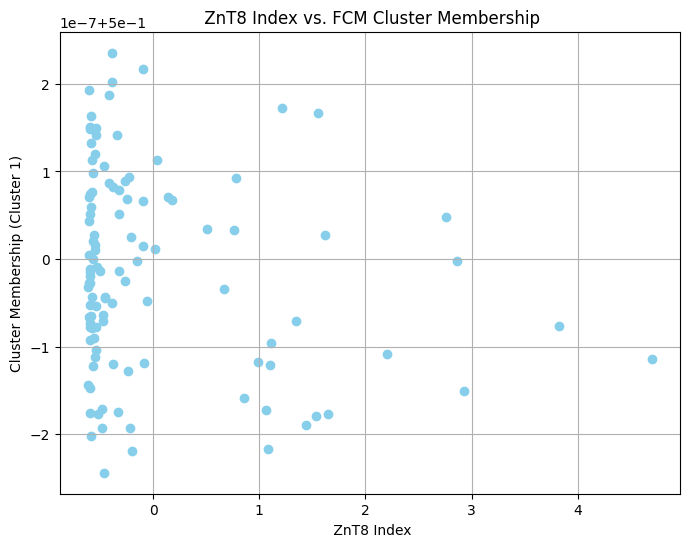

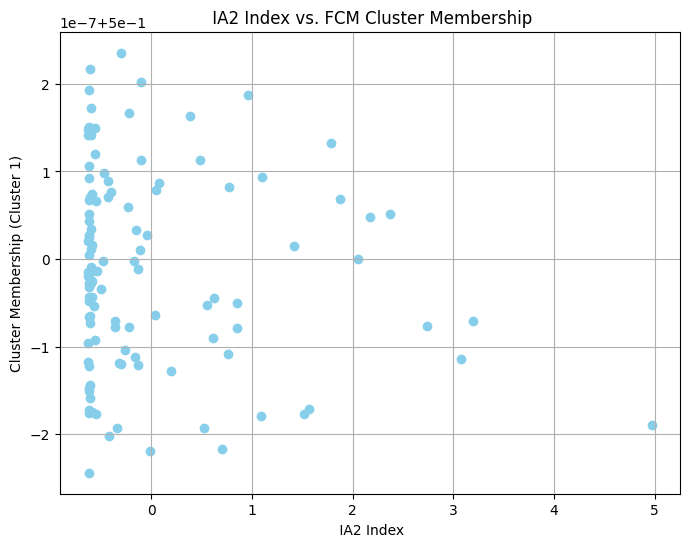

In [ ]:
#we draw the scatterplot of the ZnT8 Index  versus the cluster_labels_fcm
plt.figure(figsize=(8, 6))
plt.scatter(features_antibody['ZnT8 Index'], cluster_labels_fcm, color='skyblue')
plt.xlabel(' ZnT8 Index')
plt.ylabel('Cluster Membership (Cluster 1)')
plt.title(' ZnT8 Index vs. FCM Cluster Membership')
plt.grid(True)
plt.show()

#we draw the scatterplot of the IA2 Index  versus the cluster_labels_fcm
plt.figure(figsize=(8, 6))
plt.scatter(features_antibody['IA2 Index'], cluster_labels_fcm, color='skyblue')
plt.xlabel(' IA2 Index')
plt.ylabel('Cluster Membership (Cluster 1)')
plt.title(' IA2 Index vs. FCM Cluster Membership')
plt.grid(True)
plt.show()




In conclusion, the Fuzzy C-Means clustering results were largely driven by the MHC region SNPs and the INS genotypes. However, notice that the Fuzzy C-Means clustering membership is not a binary assignment of clusters, but a continuous value of membership probabilities between two clusters.